## Midterm: Deep Learning MCTA 4363
<span style="color:blue">
    
1) Answer all questions
    
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc

3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)

4) Upload this **answer jupyter notebook, trained model & VSCode python script (for Question 3) & video of model inference** **(for Question 3)** to your github.

5) Submit the assessment by sharing the link to your github containing the answers.
    
</span>

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is 5 x 5 x 12
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer(s)) (2 marks)

 - [X] Individual feature map
 - [ ] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is NOT an advantage of Batch Normalization (BN)? (tick X for the correct answer(s)) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [X] BN needs a much slower learning rate for the total architecture to converge.

 d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [X] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [ ]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 100 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [X] Deep neural networks usually require a big amount of data to be properly trained.
- [X] They can be fooled by adversarial/ noisy examples.
- [X] They are difficult to interpret and understand.
- [X] They can still be subject to biases.
- [ ] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell.

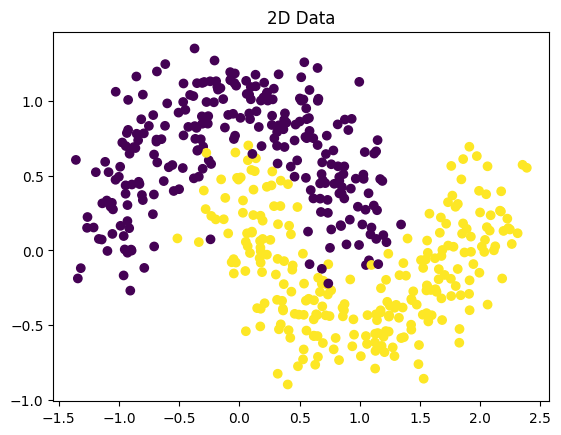

In [ ]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer: No, the data cannot be correctly separable using the above classifier. This is because the datapoints are not linearly separable, as can be seen in the plotted graph. The Linear function creates a linear decision boundary between classes, however it cannot do so effectively for this data because there is there is an overlap between the datapoints. As for the Sigmoid function, it converts the values of the input to a value between 0 and 1, which is useful for binary classification but it is still a linear separation function, thus it cannot correctly separate the non-linear datapoints. Due to the data having non-linear characteristics, a more complex model is necessary to separate it.
</span>

**QUESTION 2 [50 marks]**

To answer the following questions, gather your own dataset to solve the image classification problem of distinguishing between individuals wearing and not wearing spectacles as shown in Fig. 1.

![pic](https://i.insider.com/64e53cfd4c17ff0019baa4c0?width=1000&format=jpeg&auto=webp)

                            Fig. 1 A person wearing VS not wearing a spectable.

a) Define the *dataloader* to load the train and test datasets. Show the code in the following cell. **(5 marks)**

In [1]:
###############################################
############### YOUR CODES HERE ###############
###############################################

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


2.2.1+cu121
cuda


make data file, place glasses_noglasses.zip into data file before running following code:

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path

with zipfile.ZipFile(data_path / "glasses_noglasses.zip", "r") as zip_ref:
    print("Unzipping glasses_noglasses data...")
    zip_ref.extractall(image_path)

Unzipping glasses_noglasses data...


# Display example image

make a file named glasses_noglasses, then place the train, test and validate folders from the unzipped file into the glasses_noglasses folder, before running the following code:

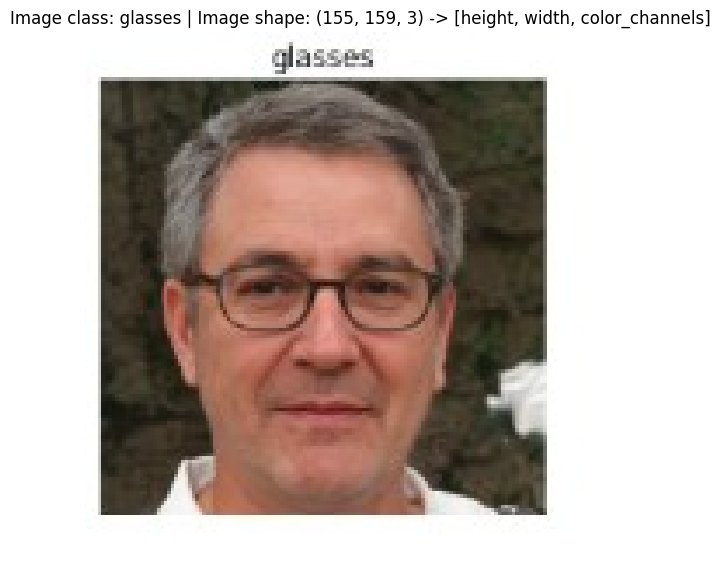

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

image_path = data_path / "glasses_noglasses"
# Set seed
random.seed(12) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [5]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

# Use torchvision.datasets.ImageFolder to create dataset(s)
from torchvision import datasets

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "validate"


train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 104
    Root location: data/glasses_noglasses/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 40
    Root location: data/glasses_noglasses/validate
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.64

In [7]:
# Get class names as a list
class_names = train_data.classes
class_names

['glasses', 'noglasses']

In [9]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

# Create iterators for the Data loaded using DataLoader module
batchSize = 4
train_dataloader = DataLoader(dataset=train_data, batch_size=batchSize, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batchSize, num_workers=1, shuffle=False)

In [10]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([4, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([4])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


b) Define a ConvNet corresponding to the following architecture in Fig. 2 (with modifications of the input and final layers). Make sure the number of layers, types of layers, the kernel size, number of feature maps, etc follow exactly the ConvNet as in the figure. **(10 marks)**

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 2: A convolutional neural network

In [15]:
###############################################
############### YOUR CODES HERE ###############
###############################################
class CNN(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16
        self.conv2 = nn.Conv2d(6, 16, 5) #2nd conv: 106x106x16
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

  c) Define your training loop and train the ConvNet. **(5 marks)**
  



In [16]:
###############################################
############### YOUR CODES HERE ###############
###############################################
classes = ('glasses', 'noglasses')
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

model = CNN()
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [17]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return model, history

In [18]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6482, Accuracy: 54.8077%, 
		Validation : Loss : 0.6280, Accuracy: 62.5000%, Time: 0.9164s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3716, Accuracy: 88.4615%, 
		Validation : Loss : 1.2159, Accuracy: 60.0000%, Time: 0.6515s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3019, Accuracy: 85.5769%, 
		Validation : Loss : 0.8347, Accuracy: 67.5000%, Time: 0.6659s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1579, Accuracy: 95.1923%, 
		Validation : Loss : 0.9202, Accuracy: 70.0000%, Time: 0.6542s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.0910, Accuracy: 97.1154%, 
		Validation : Loss : 0.8782, Accuracy: 70.0000%, Time: 0.6739s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1175, Accuracy: 96.1538%, 
		Validation : Loss : 0.6296, Accuracy: 72.5000%, Time: 0.7528s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0792, Accuracy: 97.1154%, 
		Validation : Loss : 1.0958, Accuracy: 72.5000%, Time: 0.8876s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0208, Accuracy: 100

d) Display the loss and accuracy curves of the training and testing phases. **(4 marks)**

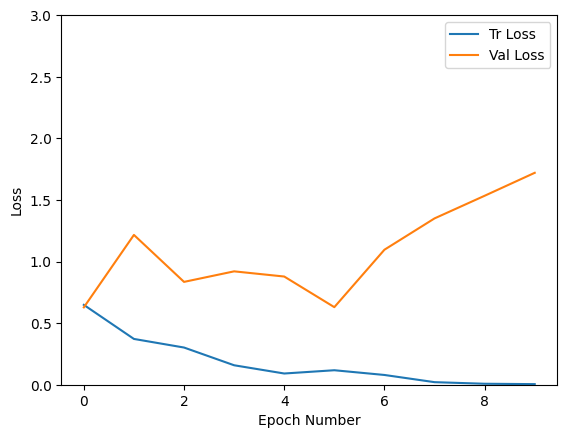

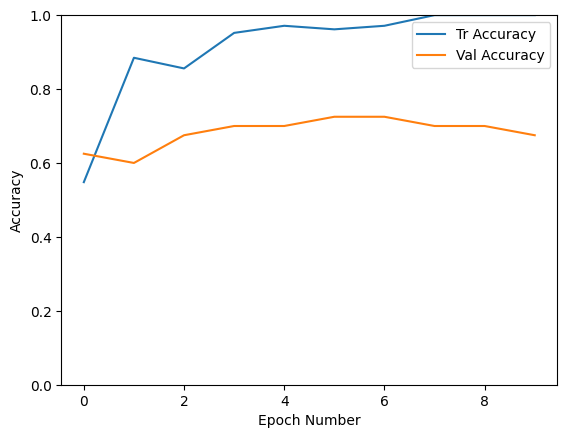

In [19]:
###############################################
############### YOUR CODES HERE ###############
###############################################
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

e) Based on Question 2 d), answer the following questions:
    
    i) Is the model showing signs of overfitting? If it is, what might be causing it? If not, why do you think it's performing well? (4 marks)
   <font color='blue'>YES, overfitting occurs. The training loss is significantly smaller than the validation loss. This is because the model has memorised the noise from the input data, instead of learning to adapt to new information. </font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) implement dropout to stop the model from memorising the noise in the training data (2) Apply batch normalisation to normalise each feature map</font>
   
    iii) Implement the two proposed methods in Q2 e) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [36]:
###############################################
############### YOUR CODES HERE ###############
###############################################
###############################################
############### YOUR CODES HERE ###############
###############################################
class CNN(nn.Module):
    def __init__(self): #sequence: input image -> 1st conv -> 1st pool -> 2nd conv -> 2nd pool -> linear layers
        super(CNN, self).__init__() #input image: 224x224x3
        self.conv1 = nn.Conv2d(3, 6, 5) #1st conv: 220x220x6
        self.BN1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2) #1st pool: 110x110x6, 2nd pool: 53x53x16
        self.conv2 = nn.Conv2d(6, 16, 5) #2nd conv: 106x106x16
        self.BN2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(53*53*16, 120)
        self.fc2 = nn.Linear(120, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.BN1(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.BN2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [37]:
###############################################
############### YOUR CODES HERE ###############
###############################################
classes = ('glasses', 'noglasses')
train_data_size = len(train_dataloader.dataset)
test_data_size = len(test_dataloader.dataset)

model = CNN()
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [38]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

    return model, history

In [39]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6642, Accuracy: 78.8462%, 
		Validation : Loss : 0.6355, Accuracy: 67.5000%, Time: 0.6502s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.5042, Accuracy: 84.6154%, 
		Validation : Loss : 1.5678, Accuracy: 57.5000%, Time: 0.6630s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3207, Accuracy: 89.4231%, 
		Validation : Loss : 0.8457, Accuracy: 70.0000%, Time: 0.6385s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2862, Accuracy: 93.2692%, 
		Validation : Loss : 2.9030, Accuracy: 52.5000%, Time: 0.6815s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2343, Accuracy: 92.3077%, 
		Validation : Loss : 1.8269, Accuracy: 65.0000%, Time: 0.6409s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2418, Accuracy: 89.4231%, 
		Validation : Loss : 1.8855, Accuracy: 62.5000%, Time: 0.6491s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3097, Accuracy: 88.4615%, 
		Validation : Loss : 3.9307, Accuracy: 55.0000%, Time: 0.6572s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.7702, Accuracy: 89.

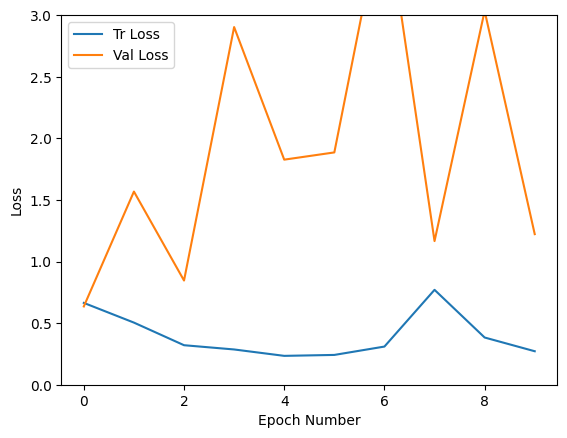

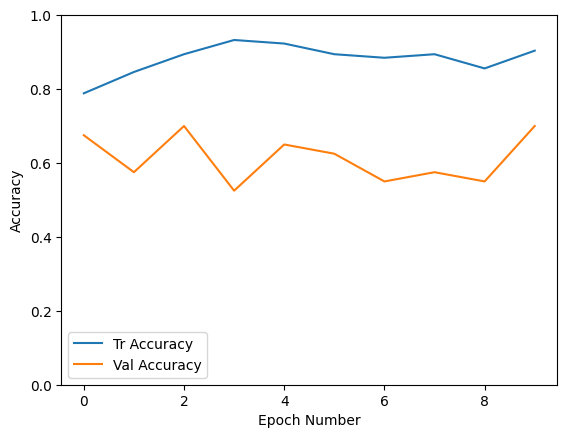

In [40]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

c) Replace your defined ConvNet in b) with a pretrained **ConvNext** model. Then, proceed with a transfer learning and finetune the model for the spectable/ no-spectacle dataset. **(10 marks)**

In [ ]:
###############################################
############### YOUR CODES HERE ###############
###############################################


# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

model = models.convnext_large(weights='DEFAULT')
num_ftrs = model.classifier[2].in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [12]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'glasses_noglasses.pt')

    return best_model, history

In [13]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 2.3672, Accuracy: 29.8077%, 
		Validation : Loss : 0.7612, Accuracy: 50.0000%, Time: 13.0892s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.7443, Accuracy: 57.6923%, 
		Validation : Loss : 0.6753, Accuracy: 57.5000%, Time: 12.1992s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.7131, Accuracy: 61.5385%, 
		Validation : Loss : 0.6417, Accuracy: 62.5000%, Time: 12.3854s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.6094, Accuracy: 70.1923%, 
		Validation : Loss : 0.5809, Accuracy: 72.5000%, Time: 12.5258s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4396, Accuracy: 79.8077%, 
		Validation : Loss : 0.2817, Accuracy: 85.0000%, Time: 11.8787s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2029, Accuracy: 91.3462%, 
		Validation : Loss : 0.0905, Accuracy: 97.5000%, Time: 11.9781s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0878, Accuracy: 99.0385%, 
		Validation : Loss : 0.0491, Accuracy: 97.5000%, Time: 12.0994s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0345, Accura

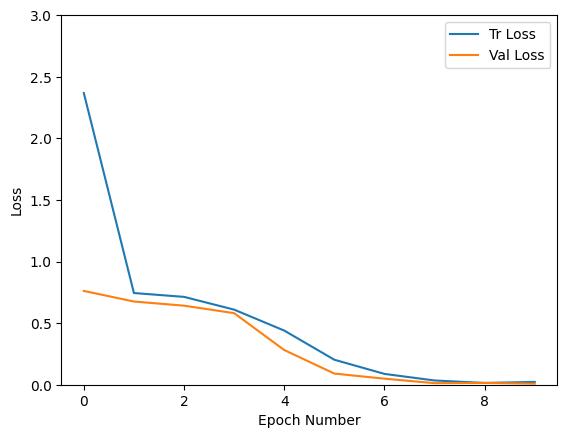

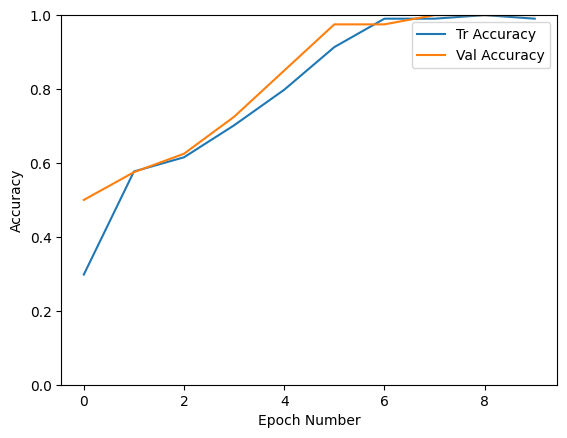

In [14]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

**QUESTION 3** **[15 marks]**

Once you have trained the ConvNext model with your custom dataset, download the model to your local machine. Next, execute the model inference in VSCode to directly determine if a person is wearing glasses or not. Capture a video of the model in action during the inference process. Please submit this video as the required deliverable for this task.

In [ ]:
###############################################
########## YOUR CODES IN VSCODE HERE ##########
###############################################
import cv2
import torch
import torchvision.transforms as transforms

model = torch.load('glasses_noglasses.pt')
model.eval()
model.to('cpu')

class_labels = ['spectacles', 'No spectacles']

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Open a connection to the camera (0 represents the default camera, or you can use a different index if you have multiple cameras)
cap = cv2.VideoCapture(0)

# Check if the camera is opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

# Read and display frames from the camera
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the frame was captured successfully
    if not ret:
        print("Error: Couldn't read frame.")
        break

    # make copy of current frame
    image = frame.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image)
    image = image.unsqueeze(0)

    # predict current gesture using model
    with torch.no_grad():
        output = model(image)

    # get output with max value
    _,predicted_class = output.max(1)
    predicted_class = predicted_class.item()

    # get class name
    predicted_class_name = class_labels[predicted_class]

    # display detected class
    cv2.putText(frame, predicted_class_name, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                2, (255,0,0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Spectacles or No Spectacles', frame)

    # Break the loop if 'Esc' key is pressed
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release the camera when done
cap.release()
cv2.destroyAllWindows()